In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#Step 1: Download a dataset and preview images


In [ ]:
# !tar -xvf './cifar100.tar'

# Step 2: Custom Data Loading

In [2]:
import os
import time
import glob
import torch
import shutil
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

config = {
    "data_path":"./cifar100",
    "batch_size": 64,
}
device = "cuda:0"

class mydataset(Dataset):
    def __init__(self, data_dir, flag, transform):
        super(mydataset,self).__init__()
        self.root       = data_dir
        self.label      = flag
        self.transform  = transform

        self.img_dir = os.path.join(self.root, self.label)
        self.img_names  = glob.glob(os.path.join(self.img_dir, '*.jpg'))

        self.tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

    def RGB2Gradient(self, img:torch.tensor):
        """
        Converts an RGB image tensor to its gradient magnitude using Sobel operator.
        The output is replicated to 3 channels to match the input dimensions of the other branch.
        """
        
        # Define Sobel kernels
        sobel_kernel_x = torch.tensor([[-1., 0., 1.], 
                                       [-2., 0., 2.], 
                                       [-1., 0., 1.]], dtype=torch.float32).reshape((1, 1, 3, 3))
        sobel_kernel_y = torch.tensor([[-1., -2., -1.], 
                                       [ 0.,  0.,  0.], 
                                       [ 1.,  2.,  1.]], dtype=torch.float32).reshape((1, 1, 3, 3))

        sobel_kernel_x = sobel_kernel_x.to(img.device)
        sobel_kernel_y = sobel_kernel_y.to(img.device)

        # Convert to grayscale: [3, H, W] -> Output [1, H, W]
        # gray_img = img[0, :, :] * 0.2989 + img[1, :, :] * 0.5870 + img[2, :, :] * 0.1140
        # gray_img = gray_img.unsqueeze(0)
        gray_img = transforms.Grayscale(num_output_channels=1)(img)

        # Add batch dimension [1, H, W] -> [1, 1, H, W]
        gray_img_batch = gray_img.unsqueeze(0) 

        # [YOU NEED TO FILL] Apply Sobel filters
        # Use F.conv2d, gray_img_batch, and the Sobel kernels (sobel_kernel_x, sobel_kernel_y) 
        # to calculate the gradients in the x and y directions.
        grad_x = F.conv2d(gray_img_batch, sobel_kernel_x, padding=1)
        grad_y = F.conv2d(gray_img_batch, sobel_kernel_y, padding=1)
        
        # [YOU NEED TO FILL] Calculate gradient magnitude ---
        # Calculate the magnitude (G = sqrt(Gx^2 + Gy^2)) from grad_x and grad_y.
        # The result should be stored in a variable named 'magnitude'.
        magnitude = torch.sqrt(grad_x.pow(2) + grad_y.pow(2))

        # Normalize magnitude
        mag_min = magnitude.min()
        mag_max = magnitude.max()
        epsilon = 1e-6 # Avoid division by zero
        normalized_magnitude = (magnitude - mag_min) / (mag_max - mag_min + epsilon)
        
        # Replicate to 3 channels [1, 1, H, W] -> [1, 3, H, W]
        normalized_magnitude_3channel = normalized_magnitude.repeat(1, 3, 1, 1)

        # Remove batch dimension [1, 3, H, W] -> [3, H, W]
        return normalized_magnitude_3channel.squeeze(0)

    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(os.path.join(img_name))
        img = self.transform(img)
        gra_img = self.RGB2Gradient(img)

        for i in range(len(self.tags)):
            if self.tags[i] in img_name:
                tag = i
                break
        
        # gra_img = gra_img.to(device)
        # img = img.to(device)
        return (gra_img, img), tag

    def __len__(self):
        return len(self.img_names)

transform_train = transforms.Compose(
        [transforms.Resize([64, 64]),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomRotation(15),
         transforms.ColorJitter(
            brightness=0.2,  # 亮度
            contrast=0.2,    # 对比度
            saturation=0.2,  # 饱和度
            hue=0.1          # 色调
         ),
         transforms.ToTensor()])
transform_test = transforms.Compose(
    [transforms.Resize([64, 64]),
      transforms.ToTensor()])

train_dataset = mydataset(data_dir=config['data_path'], flag= "train", transform=transform_train)
test_dataset  = mydataset(data_dir=config['data_path'], flag= "test", transform=transform_test)

# define data loader
train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True, drop_last=False)

test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True, drop_last=False)

# Step 3: Configure the Neural Network

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Sequential as Seq

class CommonBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride):        # 普通Block简单完成两次卷积操作
        super(CommonBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = x 
        
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)       # 完成一次卷积
        x = self.bn2(self.conv2(x))                             # 第二次卷积不加relu激活函数

        x += identity                                           # 两路相加
        return F.relu(x, inplace=True)                          # 添加激活函数输出

class SpecialBlock(nn.Module):                                  # 特殊Block完成两次卷积操作，以及一次升维下采样
    def __init__(self, in_channel, out_channel, stride):        # 注意这里的stride传入一个数组，shortcut和残差部分stride不同
        super(SpecialBlock, self).__init__()
        self.change_channel = nn.Sequential(                    # 负责升维下采样的卷积网络change_channel
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride[0], padding=0, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride[1], padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = self.change_channel(x)                       # 调用change_channel对输入修改，为后面相加做变换准备

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.bn2(self.conv2(x))                             # 完成残差部分的卷积

        x += identity
        return F.relu(x, inplace=True)                          # 输出卷积单元

class ConvNet(nn.Module):
    def __init__(self, classes_num):
        super(ConvNet, self).__init__()
        self.prepare = nn.Sequential(           # 预处理==》[batch, 64, 56, 56]
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1 = nn.Sequential(            # layer1有点特别，由于输入输出的channel均是64，故两个CommonBlock
            CommonBlock(64, 64, 1),
            CommonBlock(64, 64, 1)
        )
        self.layer2 = nn.Sequential(            # layer234类似，由于输入输出的channel不同，故一个SpecialBlock，一个CommonBlock
            SpecialBlock(64, 128, [2, 1]),
            CommonBlock(128, 128, 1)
        )
        self.layer3 = nn.Sequential(
            SpecialBlock(128, 256, [2, 1]),
            CommonBlock(256, 256, 1)
        )
        self.layer4 = nn.Sequential(
            SpecialBlock(256, 512, [2, 1]),
            CommonBlock(512, 512, 1)
        )
        self.head = Seq(nn.AdaptiveAvgPool2d(1),
                  nn.Flatten(start_dim=1),
                  nn.Linear(512, classes_num))
    def forward(self, x):
        x = self.prepare(x)         # 预处理

        x = self.layer1(x)          # 四个卷积单元
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.head(x)

        return x

class Duel_ConvNet(nn.Module):
    def __init__(self, classes_num):
        super(Duel_ConvNet, self).__init__()

        self.gradient_prepare = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.gradient_layer1 = nn.Sequential(CommonBlock(64, 64, 1), CommonBlock(64, 64, 1))
        self.gradient_layer2 = nn.Sequential(SpecialBlock(64, 128, [2, 1]), CommonBlock(128, 128, 1))
        self.gradient_layer3 = nn.Sequential(SpecialBlock(128, 256, [2, 1]), CommonBlock(256, 256, 1))
        self.gradient_layer4 = nn.Sequential(SpecialBlock(256, 512, [2, 1]), CommonBlock(512, 512, 1))

        self.rgb_prepare = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.rgb_layer1 = nn.Sequential(CommonBlock(64, 64, 1), CommonBlock(64, 64, 1))
        self.rgb_layer2 = nn.Sequential(SpecialBlock(64, 128, [2, 1]), CommonBlock(128, 128, 1))
        self.rgb_layer3 = nn.Sequential(SpecialBlock(128, 256, [2, 1]), CommonBlock(256, 256, 1))
        self.rgb_layer4 = nn.Sequential(SpecialBlock(256, 512, [2, 1]), CommonBlock(512, 512, 1))

        # self.fusion_head = nn.Linear(1024, classes_num)  # 512 + 512 = 1024
        self.fusion_head = nn.Linear(512, 128)
        self.classify_layer = nn.Linear(128, classes_num)
        
    
    def forward(self, x):
        gradient_img, rgb_img = x

        grad_feat = self.gradient_prepare(gradient_img)
        grad_feat = self.gradient_layer1(grad_feat)
        grad_feat = self.gradient_layer2(grad_feat)
        grad_feat = self.gradient_layer3(grad_feat)
        grad_feat = self.gradient_layer4(grad_feat)

        rgb_feat = self.rgb_prepare(rgb_img)
        rgb_feat = self.rgb_layer1(rgb_feat)
        rgb_feat = self.rgb_layer2(rgb_feat)
        rgb_feat = self.rgb_layer3(rgb_feat)
        rgb_feat = self.rgb_layer4(rgb_feat)

        grad_feat = nn.AdaptiveAvgPool2d(1)(grad_feat).flatten(1)
        rgb_feat = nn.AdaptiveAvgPool2d(1)(rgb_feat).flatten(1)

        # fused = torch.cat([grad_feat, rgb_feat], dim=1)
        fused = 0.5*grad_feat + 0.5*rgb_feat

        out = self.fusion_head(fused)
        out = nn.ReLU()(out)
        out = self.classify_layer(out)
        
        return out

config = {
    "lr":1e-2,
    "momentum":0.9,
    "weight_decay":1e-4,
}

device = torch.device("cuda:0")
net_sgl = ConvNet(classes_num=100).to(device)
net_duel = Duel_ConvNet(classes_num=100).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer_sgl = torch.optim.SGD(net_sgl.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
optimizer_duel = torch.optim.SGD(net_duel.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_duel,
                                                            mode='min',
                                                            factor=0.1,
                                                            patience=5)

# Step 4: Train the network and save model

In [27]:
import time
from tqdm import tqdm

class AverageMeter(object):
    def __init__(self):
      self.reset()

    def reset(self):
      self.val   = 0
      self.avg   = 0
      self.sum   = 0
      self.count = 0

    def update(self, val, n=1):
      self.val   = val
      self.sum   += val * n
      self.count += n
      self.avg   = self.sum / self.count

def accuracy(output, target, topk=(1,1)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

def train(train_loader, net, optimizer, criterion, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    top1       = AverageMeter()

    LOSS = AverageMeter()

    net.train()

    end = time.time()

    if epoch % 10 == 1:
        print(f"Start Train Epoch: {epoch}")
    
    for i, (img, target) in enumerate(tqdm(train_loader), start=1):
        data_time.update(time.time() - end)

        img = img[0].to(device), img[1].to(device)
        target = target.to(device)

        out = net(img)

        loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        top1.update(prec1.item(), img[0].size(0))

        LOSS.update(loss.item(), img[0].size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()
    
    scheduler.step(loss)
    # if i % 50 == 1:
    log_str = ('Epoch[{0}] '
                'Time:{batch_time.val:.4f} '
                'Data:{data_time.val:.4f}  '
                'loss:{loss.avg:.4f}  '
                'prec@1:{top1.avg:.2f}  '.format(
                epoch, len(train_loader), batch_time=batch_time, data_time=data_time,
                loss=LOSS,
                top1=top1))
    print(log_str)

    return LOSS.avg

def test(test_loader, net, criterion):
    losses = AverageMeter()
    top1   = AverageMeter()

    net.eval()

    for i, (img, target) in enumerate(test_loader, start=1):
        img = img[0].to(device), img[1].to(device)
        target = target.to(device)

        with torch.no_grad():
            out = net(img)
            loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        losses.update(loss.item(), img[0].size(0))
        top1.update(prec1.item(), img[0].size(0))

    f_l = [losses.avg, top1.avg]
    print('---------------------------------test classification result---------------------------------')
    print('Loss: {:.4f}, Prec@1: {:.2f}%'.format(*f_l))

    return top1.avg


def save_checkpoint(state, is_best, save_root, epoch):
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    save_path = os.path.join(save_root, 'epoch_{}.pth.tar'.format(str(epoch)))
    torch.save(state, save_path)
    if is_best:
        best_save_path = os.path.join(save_root, 'model_best.pth.tar')
        shutil.copyfile(save_path, best_save_path)
   


config = {
    "save_root":"./result",
    "epochs": 30,
}

best_top1 = 0
test_top1 = 0


start_epoch = 1
flag_resume = True

if flag_resume:
   load_path = "./result/epoch_30.pth.tar"
   checkpoint = torch.load(load_path, map_location=device)
   net_duel.load_state_dict(checkpoint['net'])
   start_epoch = checkpoint['epoch'] + 1
   best_top1 = checkpoint['prec@1']

for epoch in range(start_epoch, config["epochs"]+1):
    # train one epoch
    epoch_start_time = time.time()

    # TODO: add a load part
    path = f"./result/epoch_{epoch}.pth.tar"
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        net_duel.load_state_dict(checkpoint['net'])
        print(f"Load epoch_{epoch}.pth.tar")
    else: 
        # print(f"Training epoch: {epoch}")
        train_loss = train(train_loader, net_duel, optimizer_duel, criterion, epoch)

    # evaluate on testing set
    test_top1 = test(test_loader, net_duel, criterion)

    epoch_duration = time.time() - epoch_start_time
    print('Epoch time: {}s'.format(int(epoch_duration)))

    # save model
    is_best = False
    if test_top1 > best_top1:
        best_top1 = test_top1
        is_best = True

    if test_top1 > best_top1 or epoch % 2 == 0:
        print('Saving models......')
        save_checkpoint({
            'epoch': epoch,
            'net': net_duel.state_dict(),
            'prec@1': test_top1,
        }, is_best, config["save_root"], epoch)

# Step 5: Test on single image

In [28]:
load_path = "./result/epoch_30.pth.tar"
checkpoint = torch.load(load_path, map_location=device)
net_duel.load_state_dict(checkpoint['net'])
start_epoch = checkpoint['epoch'] + 1
best_top1 = checkpoint['prec@1']

In [29]:
img = Image.open("./cifar100/test/apple_9904.jpg")
img = transform_test(img)
gra_img = test_dataset.RGB2Gradient(img).unsqueeze(0).to(device)
img = img.unsqueeze(0).to(device)
out = net_duel((gra_img, img))
predicted_classes = torch.argmax(out, dim=1)
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

print(tags[predicted_classes[0]])

apple


# Step 6: Evaluate model accuracy

In [30]:
test_top1 = test(test_loader, net_duel, criterion)

---------------------------------test classification result---------------------------------
Loss: 3.3745, Prec@1: 54.96%


# Step 7: T-SNE Visualization

##Use hooks in PyTorch to extract feature representations from the intermediate layers of the model for the test set "testloader", and visualize them using the T-SNE method. The specific requirements are as follows:
####Visualize the features before and after the dual-branch feature fusion. If there are multiple fusions, you may choose specific layers for visualization.


Starting T-SNE Visualization


Extracting features:  10%|█         | 16/157 [00:01<00:11, 12.50it/s]



Extracted features:
  Gradient branch: (1024, 2048)
  RGB branch: (1024, 2048)
  Fused features: (1024, 128)
  Labels: (1024,)

Visualizing comparison: Before vs After fusion

Running T-SNE on Gradient Branch
(Before Fusion)...

Running T-SNE on RGB Branch
(Before Fusion)...

Running T-SNE on Fused Features
(After Fusion)...

Visualization saved to tsne_comparison.png


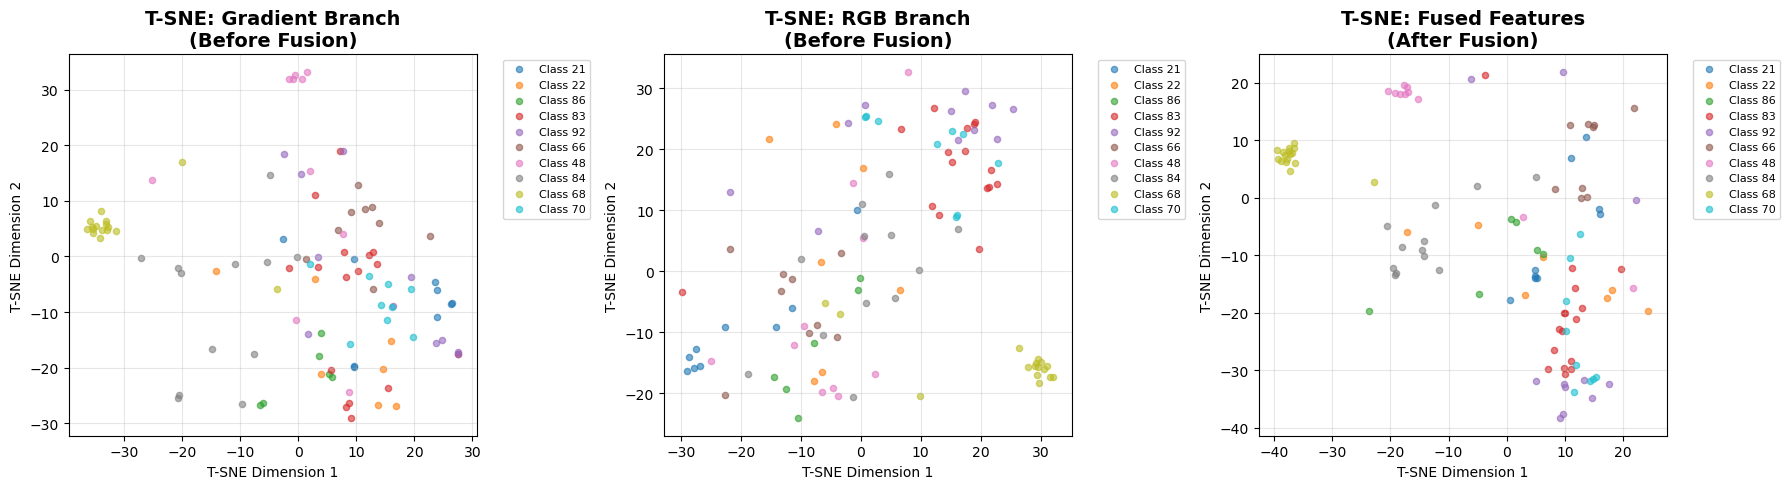

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm

# Step 7: T-SNE Visualization
def extract_features_with_hooks(model, dataloader, device, max_samples=1000):

    model.eval()

    grad_features = []
    rgb_features = []
    fused_features = []
    labels = []
    
    def hook_grad_feat(module, input, output):
        feat = output.detach()
        feat = feat.flatten(1)
        grad_features.append(feat.cpu())
    
    def hook_rgb_feat(module, input, output):
        feat = output.detach()
        feat = feat.flatten(1)
        rgb_features.append(feat.cpu())
    
    def hook_fused_feat(module, input, output):
        feat = output.detach()
        feat = feat.flatten(1)
        fused_features.append(feat.cpu())
    
    hook1 = model.gradient_layer4.register_forward_hook(hook_grad_feat)
    hook2 = model.rgb_layer4.register_forward_hook(hook_rgb_feat)
    hook3 = model.fusion_head.register_forward_hook(hook_fused_feat)
    
    sample_count = 0
    with torch.no_grad():
        for img, target in tqdm(dataloader, desc="Extracting features"):
            if sample_count >= max_samples:
                break
            
            img = img[0].to(device), img[1].to(device)
            target = target.to(device)
            
            _ = model(img)  # 触发hooks
            
            labels.append(target.cpu())
            sample_count += img[0].size(0)

    hook1.remove()
    hook2.remove()
    hook3.remove()

    grad_features = torch.cat(grad_features, dim=0).numpy()
    rgb_features = torch.cat(rgb_features, dim=0).numpy()
    fused_features = torch.cat(fused_features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    return grad_features, rgb_features, fused_features, labels


def visualize_tsne(features_dict, labels, save_path='tsne_visualization.png', selected_classes = []):

    n_plots = len(features_dict)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
    
    if n_plots == 1:
        axes = [axes]
    
    for idx, (name, features) in enumerate(features_dict.items()):
        print(f"\nRunning T-SNE on {name}...")

        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        features_2d = tsne.fit_transform(features)
        
        ax = axes[idx]
        

        
        for label in selected_classes:
            mask = (labels == label)
            ax.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                      label=f'Class {label}', alpha=0.6, s=20)
        
        ax.set_title(f'T-SNE: {name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('T-SNE Dimension 1')
        ax.set_ylabel('T-SNE Dimension 2')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nVisualization saved to {save_path}")
    plt.show()


def run_tsne_visualization():

    print("=" * 60)
    print("Starting T-SNE Visualization")
    print("=" * 60)

    grad_feat, rgb_feat, fused_feat, labels = extract_features_with_hooks(
        model=net_duel,
        dataloader=test_loader,
        device=device,
        max_samples=1000  # 暂时使用1000个样本
    )
    
    print(f"\nExtracted features:")
    print(f"  Gradient branch: {grad_feat.shape}")
    print(f"  RGB branch: {rgb_feat.shape}")
    print(f"  Fused features: {fused_feat.shape}")
    print(f"  Labels: {labels.shape}")
    
    unique_labels = np.unique(labels)
    n_classes_to_show = min(10, len(unique_labels))
    selected_classes = np.random.choice(unique_labels, n_classes_to_show, replace=False)

    # print("\n" + "=" * 60)
    # print("Visualizing features BEFORE fusion")
    # print("=" * 60)
    # visualize_tsne(
    #     features_dict={
    #         'Gradient Branch': grad_feat,
    #         'RGB Branch': rgb_feat
    #     },
    #     labels=labels,
    #     save_path='tsne_before_fusion.png',
    #     selected_classes=selected_classes
    # )
    
    # print("\n" + "=" * 60)
    # print("Visualizing features AFTER fusion")
    # print("=" * 60)

    # visualize_tsne(
    #     features_dict={
    #         'Fused Features': fused_feat
    #     },
    #     labels=labels,
    #     save_path='tsne_after_fusion.png',
    #     selected_classes=selected_classes
    # )
    
    print("\n" + "=" * 60)
    print("Visualizing comparison: Before vs After fusion")
    print("=" * 60)
    visualize_tsne(
        features_dict={
            'Gradient Branch\n(Before Fusion)': grad_feat,
            'RGB Branch\n(Before Fusion)': rgb_feat,
            'Fused Features\n(After Fusion)': fused_feat
        },
        labels=labels,
        save_path='tsne_comparison.png',
        selected_classes=selected_classes
    )

run_tsne_visualization()